<a href="https://colab.research.google.com/github/balszeg/Deep_learning_uniproject/blob/main/Semester_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Milestone #1 ##


Importing the necessary libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import csv
import tensorflow as tf
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
from IPython.display import clear_output

Cloning the chosen X-ray datasets into our content folder. Our goal is to predict if it depicts COVID-19 caused pneumonia or not. Initially, we'll use a smaller amount of data to find out which model is the most adaptable for our purposes.

In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git
!git clone https://github.com/agchung/Figure1-COVID-chestxray-dataset.git
!git clone https://github.com/agchung/Actualmed-COVID-chestxray-dataset.git

os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip \*.zip  && rm *.zip

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3622 (delta 3), reused 2 (delta 0), pack-reused 3614
Receiving objects: 100% (3622/3622), 632.88 MiB | 47.25 MiB/s, done.
Resolving deltas: 100% (1436/1436), done.
Checking out files: 100% (1173/1173), done.
Cloning into 'Figure1-COVID-chestxray-dataset'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 112 (delta 28), reused 95 (delta 14), pack-reused 0
Receiving objects: 100% (112/112), 14.13 MiB | 44.11 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Cloning into 'Actualmed-COVID-chestxray-dataset'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 422 (delta 1), reused 6 (delta 1), pack-reused 412
R

Setting the path for the images, and reading there names in a list.

In [ ]:
image_path ='/content/covid-chestxray-dataset/images'
image_names=os.listdir(image_path)

Read the labels for the learning from a CSV file and put the names of the X-rays into an another list with the same order.


In [ ]:
x_raw_name=[] # the names of the pictures
y_label=[] # pcr test: True=+, False=-
images = [] # array for the actual images

with open('/content/covid-chestxray-dataset/metadata.csv') as csv_file: #load the csv from the session storage
    csv_reader = csv.reader(csv_file, delimiter=',') # ',' is the separating character
    line_count = 0 # line counter
    for row in csv_reader:
        if line_count == 0:
            # print("Images, PCR_test result") #the 0.th row is just a header
            line_count = 1
        else:
            if row[23] in image_names: # check if we have the x-ray image for this diagnosis
                if row[5]=='': # negative covid test
                  y_label.append(False)
                if row[5]=='Y': #positive covid test
                  y_label.append(True)
                if row[5]=='Y' or row[5]=='':
                  x_raw_name.append(row[23])
                  img = cv2.imread(image_path + '/' + x_raw_name[-1],0) # load the image
                  img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA) # resize the image to 224x224
                  images.append(img)
                  line_count += 1
    # print(f'Processed {line_count} lines.')
    print('As we can see we only have',f'{line_count-1} examples.')
    images = np.asarray(images)
    y_label = np.asarray(y_label)
    print('The shape of the np.array is: ',images.shape)

As we can see we only have 719 examples.
The shape of the np.array is:  (719, 224, 224)


Lets check some data now: all the images are 224x224 now

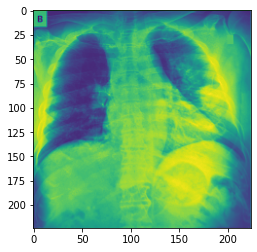

In [ ]:
plt.imshow(images[1]) # the most of the images are "front"

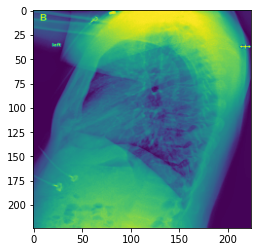

In [ ]:
plt.imshow(images[25]) #some of them has taken from the side.

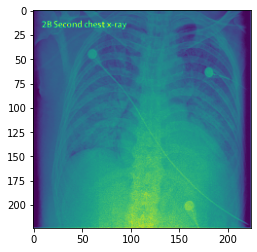

In [ ]:
plt.imshow(images[8]) # in some picture we can see wires and other medical equipments, it will might be hard to ignore and separate them from the important data: the pneumonia, during the deep learning
#the labels in the pictures also can cause some issue

Normalizing the images

In [ ]:
# "normalize" the images
normalized = images.astype(float)
for i in range(len(normalized)):
  normalized[i] = normalized[i]/255 # all pixel value between 0 and 1

## Milestone #2


First we are going to try a hand made CNN, see how it works.

Splitting the data into training, testing and validation sets

In [ ]:
# split the data into train, test, and validation arrays
x_train, x_2, y_train, y_2 = train_test_split(normalized, y_label, test_size=0.3, shuffle=True) # 70% of the data is the train data, 30% is for test and validation
x_valid, x_test, y_valid, y_test = train_test_split(x_2, y_2, test_size=0.33, shuffle=True) # Two thirds of the remaining 33% is the validation data and the remaining is for test
# shape of the arrays
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(503, 224, 224)
(144, 224, 224)
(72, 224, 224)
(503,)
(144,)
(72,)


Building and training of a self-designed CNN


In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn
from keras.models import load_model

In [ ]:
x_train = x_train.reshape(x_train.shape[0],224,224,1)
x_valid = x_valid.reshape(x_valid.shape[0],224,224,1)
x_test = x_test.reshape(x_test.shape[0],224,224,1)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (8, 8), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
checkpointer=ModelCheckpoint(filepath='HandMade.h5',save_best_only=True,verbose=1,) #We save the best model with checkpointer

In [ ]:
model.fit(x_train, y_train, epochs=30, batch_size=24, validation_data=(x_valid, y_valid),callbacks=[checkpointer,earlystopping])

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.1037 - accuracy: 0.5388WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0031s vs `on_test_batch_end` time: 0.0075s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.69253, saving model to HandMade.h5
21/21 [==============================] - 3s 121ms/step - loss: 1.1037 - accuracy: 0.5388 - val_loss: 0.6925 - val_accuracy: 0.5208
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.5169
Epoch 00002: val_loss improved from 0.69253 to 0.68678, saving model to HandMade.h5
21/21 [==============================] - 3s 130ms/step - loss: 0.6974 - accuracy: 0.5169 - val_loss: 0.6868 - val_accuracy: 0.5417
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5646
Epoch 00003: val_loss improved from 0.68678 to 0.67933, saving model to HandMade.h5
21/21 [============================

Text(0.5, 1.0, 'HandMade')

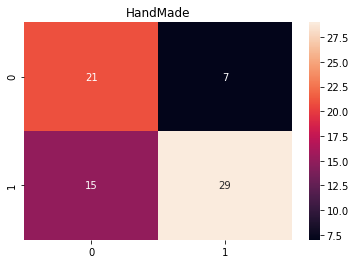

In [ ]:
model=load_model('HandMade.h5')
predict = model.predict(x_test) # predict the output for all test images
for i in range(len(predict)):
  if predict[i] > 0.5:
    predict[i] = 1
  else:
    predict[i] = 0
conf_matrix = confusion_matrix(y_test, predict) # create a confusion matrix from the model output and the correct solution of the test database
seaborn.heatmap(conf_matrix, annot=True) # show the results on a heatmap
plt.title('HandMade')

Now lets try some transfer learning. We are going to use these ImageNet pre-trained models: 

*   VGG16
*   VGG19
*   ResNet-50V2
*   ResNet-151V2
*   Xception
*   DenseNet121
*   MobilNetV2
*   InceptionResNetV2
*   InceptionV3

Prepare the data for the network's input

In [ ]:
#The input of this network is 3 chaneled RGB image, but we only have greyscale images. Lets just use our 1 chanel for each 3 RGB chanel to make it work.
print(len(normalized[:,0,0]))
print(len(normalized[0,:,0]))
print(len(normalized[0,0,:]))

triplechanel=np.zeros([len(normalized[:,0,0]),len(normalized[0,:,0]),len(normalized[0,0,:]),3]) #the shape of our new input

print('Our new input shape:', triplechanel.shape)
triplechanel[:,:,:,0], triplechanel[:,:,:,1], triplechanel[:,:,:,2] = normalized, normalized, normalized

719
224
224
Our new input shape: (719, 224, 224, 3)


In [ ]:
# split the data into train, test, and validation arrays
x_train, x_2, y_train, y_2 = train_test_split(triplechanel, y_label, test_size=0.3, shuffle=True) # 70% of the data is the train data, 30% is for test and validation
x_valid, x_test, y_valid, y_test = train_test_split(x_2, y_2, test_size=0.33, shuffle=True) # Two thirds of the remaining 33% is the validation data and the remaining is for test
# shape of the arrays
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(503, 224, 224, 3)
(144, 224, 224, 3)
(72, 224, 224, 3)
(503,)
(144,)
(72,)


In [ ]:
def TransferLearningModel(type):
  # loading the 'type' network, ensuring the head FC-layer sets are left off
  if type=='VGG16':
    baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='VGG19':
    baseModel = tf.keras.applications.VGG19(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='ResNet50V2':
    baseModel = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='ResNet152V2':
    baseModel = tf.keras.applications.ResNet152V2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='Xception':
    baseModel = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='DenseNet121':
    baseModel = tf.keras.applications.DenseNet121(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='MobilNetV2':
    baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='InceptionResNetV2':
    baseModel = tf.keras.applications.InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  elif type=='InceptionV3':
    baseModel = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  else:
    print('Wrong type, use valid pertrained keras model.')
  # construct the head of the model that will be placed on top of the the base model
  output = baseModel.output
  output = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(output) #first we use 2 layers MLP on the top of the pretrained CNN
  output = tf.keras.layers.Flatten(name="flatten")(output)
  output = tf.keras.layers.Dense(256, activation="relu")(output) # we are going to use the same MLPs as head, we will optimise them later
  output = tf.keras.layers.Dropout(0.5)(output)
  output = tf.keras.layers.Dense(512, activation="relu")(output)
  output = tf.keras.layers.Dropout(0.5)(output)
  output = tf.keras.layers.Dense(1, activation="sigmoid")(output)
  # place the head FC model on top of the base model
  model = tf.keras.Model(inputs=baseModel.input, outputs=output)
  # loop over all layers in the base model and freeze them so they will not be updated during the first training process
  for layer in baseModel.layers:
    layer.trainable = False
  return model

In [ ]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 0.001
EPOCHS = 40
BATCHSIZE = 32 

# defining the optimizer
optimizer = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS) #we always use thoose hyperparameters to check which pretrained CNN is the ebst for us.

STEP_TRAIN = len(x_train) // BATCHSIZE
STEP_VALID = len(x_valid) // BATCHSIZE

#1. VGG16

In [ ]:
model = TransferLearningModel('VGG16')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

58892288/58889256 [==============================] - 0s 0us/step
Compiling model:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________

In [ ]:
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
checkpointer=ModelCheckpoint(filepath='VGG16.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[earlystopping,checkpointer])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 0.8609 - accuracy: 0.5104
Epoch 00001: val_loss improved from inf to 0.64456, saving model to VGG16.h5
15/15 [==============================] - 2s 163ms/step - loss: 0.8609 - accuracy: 0.5104 - val_loss: 0.6446 - val_accuracy: 0.5781
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.7270 - accuracy: 0.5456
Epoch 00002: val_loss improved from 0.64456 to 0.63916, saving model to VGG16.h5
15/15 [==============================] - 2s 149ms/step - loss: 0.7270 - accuracy: 0.5456 - val_loss: 0.6392 - val_accuracy: 0.6016
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.6136
Epoch 00003: val_loss did not improve from 0.63916
15/15 [==============================] - 2s 139ms/step - loss: 0.6550 - accuracy: 0.6136 - val_loss: 0.6575 - val_accuracy: 0.5469
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.6330 - accuracy: 0.6285
Epoch 00004: val_loss 

#2. VGG19

In [ ]:
model = TransferLearningModel('VGG19')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

80142336/80134624 [==============================] - 1s 0us/step
Compiling model:
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________

In [ ]:
checkpointer=ModelCheckpoint(filepath='VGG19.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 1.0508 - accuracy: 0.5083
Epoch 00001: val_loss improved from inf to 0.65080, saving model to VGG19.h5
15/15 [==============================] - 3s 202ms/step - loss: 1.0508 - accuracy: 0.5083 - val_loss: 0.6508 - val_accuracy: 0.6406
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.7154 - accuracy: 0.5414
Epoch 00002: val_loss did not improve from 0.65080
15/15 [==============================] - 3s 172ms/step - loss: 0.7154 - accuracy: 0.5414 - val_loss: 0.7108 - val_accuracy: 0.4922
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.5881
Epoch 00003: val_loss improved from 0.65080 to 0.63692, saving model to VGG19.h5
15/15 [==============================] - 3s 187ms/step - loss: 0.6733 - accuracy: 0.5881 - val_loss: 0.6369 - val_accuracy: 0.6172
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.6072
Epoch 00004: val_loss 

#3. ResNet-50V2

In [ ]:
model = TransferLearningModel('ResNet50V2')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

94674944/94668760 [==============================] - 0s 0us/step
Compiling model:
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_____

In [ ]:
checkpointer=ModelCheckpoint(filepath='ResNet50V2.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 3.9654 - accuracy: 0.5292
Epoch 00001: val_loss improved from inf to 1.29375, saving model to ResNet50V2.h5
15/15 [==============================] - 3s 201ms/step - loss: 3.9654 - accuracy: 0.5292 - val_loss: 1.2938 - val_accuracy: 0.6172
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 1.6197 - accuracy: 0.6412
Epoch 00002: val_loss improved from 1.29375 to 1.21598, saving model to ResNet50V2.h5
15/15 [==============================] - 2s 156ms/step - loss: 1.6197 - accuracy: 0.6412 - val_loss: 1.2160 - val_accuracy: 0.6406
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.8956 - accuracy: 0.7219
Epoch 00003: val_loss improved from 1.21598 to 0.68971, saving model to ResNet50V2.h5
15/15 [==============================] - 2s 153ms/step - loss: 0.8956 - accuracy: 0.7219 - val_loss: 0.6897 - val_accuracy: 0.6250
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.6

#4 ResNet-152V2

In [ ]:
model = TransferLearningModel('ResNet152V2')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

234553344/234545216 [==============================] - 3s 0us/step
Compiling model:
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___

In [ ]:
checkpointer=ModelCheckpoint(filepath='ResNet152V2.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 6.8099 - accuracy: 0.5021
Epoch 00001: val_loss improved from inf to 1.12704, saving model to ResNet152V2.h5
15/15 [==============================] - 8s 510ms/step - loss: 6.8099 - accuracy: 0.5021 - val_loss: 1.1270 - val_accuracy: 0.4922
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 1.2698 - accuracy: 0.5648
Epoch 00002: val_loss improved from 1.12704 to 0.93178, saving model to ResNet152V2.h5
15/15 [==============================] - 6s 399ms/step - loss: 1.2698 - accuracy: 0.5648 - val_loss: 0.9318 - val_accuracy: 0.5625
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.7887 - accuracy: 0.6263
Epoch 00003: val_loss improved from 0.93178 to 0.64369, saving model to ResNet152V2.h5
15/15 [==============================] - 6s 394ms/step - loss: 0.7887 - accuracy: 0.6263 - val_loss: 0.6437 - val_accuracy: 0.6172
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 

# 5. Xception

In [ ]:
model = TransferLearningModel('Xception')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

83689472/83683744 [==============================] - 0s 0us/step
Compiling model:
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_____

In [ ]:
checkpointer=ModelCheckpoint(filepath='Xception.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 4.2039 - accuracy: 0.5104
Epoch 00001: val_loss improved from inf to 0.89616, saving model to Xception.h5
15/15 [==============================] - 4s 288ms/step - loss: 4.2039 - accuracy: 0.5104 - val_loss: 0.8962 - val_accuracy: 0.5781
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.8162 - accuracy: 0.5711
Epoch 00002: val_loss improved from 0.89616 to 0.73243, saving model to Xception.h5
15/15 [==============================] - 4s 239ms/step - loss: 0.8162 - accuracy: 0.5711 - val_loss: 0.7324 - val_accuracy: 0.5625
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.6008
Epoch 00003: val_loss improved from 0.73243 to 0.62529, saving model to Xception.h5
15/15 [==============================] - 3s 232ms/step - loss: 0.6697 - accuracy: 0.6008 - val_loss: 0.6253 - val_accuracy: 0.6406
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.6188 - 

# 6. DenseNet121

In [ ]:
model = TransferLearningModel('DenseNet121')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

29089792/29084464 [==============================] - 0s 0us/step
Compiling model:
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____

In [ ]:
checkpointer=ModelCheckpoint(filepath='DenseNet121.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 5.8682 - accuracy: 0.4750
Epoch 00001: val_loss improved from inf to 0.69281, saving model to DenseNet121.h5
15/15 [==============================] - 4s 280ms/step - loss: 5.8682 - accuracy: 0.4750 - val_loss: 0.6928 - val_accuracy: 0.5078
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.8602 - accuracy: 0.4947
Epoch 00002: val_loss improved from 0.69281 to 0.62474, saving model to DenseNet121.h5
15/15 [==============================] - 3s 188ms/step - loss: 0.8602 - accuracy: 0.4947 - val_loss: 0.6247 - val_accuracy: 0.5234
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.5541
Epoch 00003: val_loss improved from 0.62474 to 0.61974, saving model to DenseNet121.h5
15/15 [==============================] - 3s 182ms/step - loss: 0.6452 - accuracy: 0.5541 - val_loss: 0.6197 - val_accuracy: 0.5156
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 

# 7. MobilNetV2

In [ ]:
model = TransferLearningModel('MobilNetV2')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

9412608/9406464 [==============================] - 0s 0us/step
Compiling model:
Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______

In [ ]:
checkpointer=ModelCheckpoint(filepath='MobilNetV2.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 5.8914 - accuracy: 0.5583
Epoch 00001: val_loss improved from inf to 1.05066, saving model to MobilNetV2.h5
15/15 [==============================] - 2s 152ms/step - loss: 5.8914 - accuracy: 0.5583 - val_loss: 1.0507 - val_accuracy: 0.6719
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 1.2772 - accuracy: 0.6306
Epoch 00002: val_loss improved from 1.05066 to 0.57698, saving model to MobilNetV2.h5
15/15 [==============================] - 2s 101ms/step - loss: 1.2772 - accuracy: 0.6306 - val_loss: 0.5770 - val_accuracy: 0.6328
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6430 - accuracy: 0.6688
Epoch 00003: val_loss did not improve from 0.57698
15/15 [==============================] - 1s 52ms/step - loss: 0.6430 - accuracy: 0.6688 - val_loss: 0.6399 - val_accuracy: 0.6484
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.6100 - accuracy: 0.6306
Epoch 00004: 

# 8. InceptionResNetV2

In [ ]:
model = TransferLearningModel('InceptionResNetV2')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

219062272/219055592 [==============================] - 1s 0us/step
Compiling model:
Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 111, 111, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 111, 111, 32) 96          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_4[0][0]      
__

In [ ]:
checkpointer=ModelCheckpoint(filepath='InceptionResNetV2.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 5.9815 - accuracy: 0.4958
Epoch 00001: val_loss improved from inf to 0.66416, saving model to InceptionResNetV2.h5
15/15 [==============================] - 7s 500ms/step - loss: 5.9815 - accuracy: 0.4958 - val_loss: 0.6642 - val_accuracy: 0.5547
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 1.5063 - accuracy: 0.4671
Epoch 00002: val_loss did not improve from 0.66416
15/15 [==============================] - 3s 211ms/step - loss: 1.5063 - accuracy: 0.4671 - val_loss: 0.6888 - val_accuracy: 0.4922
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.5414
Epoch 00003: val_loss did not improve from 0.66416
15/15 [==============================] - 3s 209ms/step - loss: 0.6760 - accuracy: 0.5414 - val_loss: 0.6856 - val_accuracy: 0.5234
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.5541
Epoch 00004: val_loss improved from 0.66

# 9. InceptionV3

In [ ]:
model = TransferLearningModel('InceptionV3')
print("Compiling model:")
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# printing the model structure
print(model.summary())

87916544/87910968 [==============================] - 1s 0us/step
Compiling model:
Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 111, 111, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_207 (BatchN (None, 111, 111, 32) 96          conv2d_210[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_207[0][0]    
____

In [ ]:
checkpointer=ModelCheckpoint(filepath='InceptionV3.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 7.2048 - accuracy: 0.5437
Epoch 00001: val_loss improved from inf to 0.97006, saving model to InceptionV3.h5
15/15 [==============================] - 3s 233ms/step - loss: 7.2048 - accuracy: 0.5437 - val_loss: 0.9701 - val_accuracy: 0.4141
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 1.0245 - accuracy: 0.5584
Epoch 00002: val_loss improved from 0.97006 to 0.71710, saving model to InceptionV3.h5
15/15 [==============================] - 3s 168ms/step - loss: 1.0245 - accuracy: 0.5584 - val_loss: 0.7171 - val_accuracy: 0.5703
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.5520
Epoch 00003: val_loss improved from 0.71710 to 0.65565, saving model to InceptionV3.h5
15/15 [==============================] - 3s 177ms/step - loss: 0.7064 - accuracy: 0.5520 - val_loss: 0.6556 - val_accuracy: 0.5625
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 

# Evaulation
 Lets take a closer look at the predicts

Plot the heatmaps of the test data prediction



In [ ]:
def MakeHeatmap(WeightsFile,X_test,Y_test,border):
  model=load_model(WeightsFile)
  predict = model.predict(X_test) # predict the output for all test images
  for i in range(len(predict)):
    if predict[i] > border:
      predict[i] = 1
    else:
      predict[i] = 0
  conf_matrix = confusion_matrix(Y_test, predict) # create a confusion matrix from the model output and the correct solution of the test database
  seaborn.heatmap(conf_matrix, annot=True) # show the results on a heatmap
  plt.title(WeightsFile[0:-3])

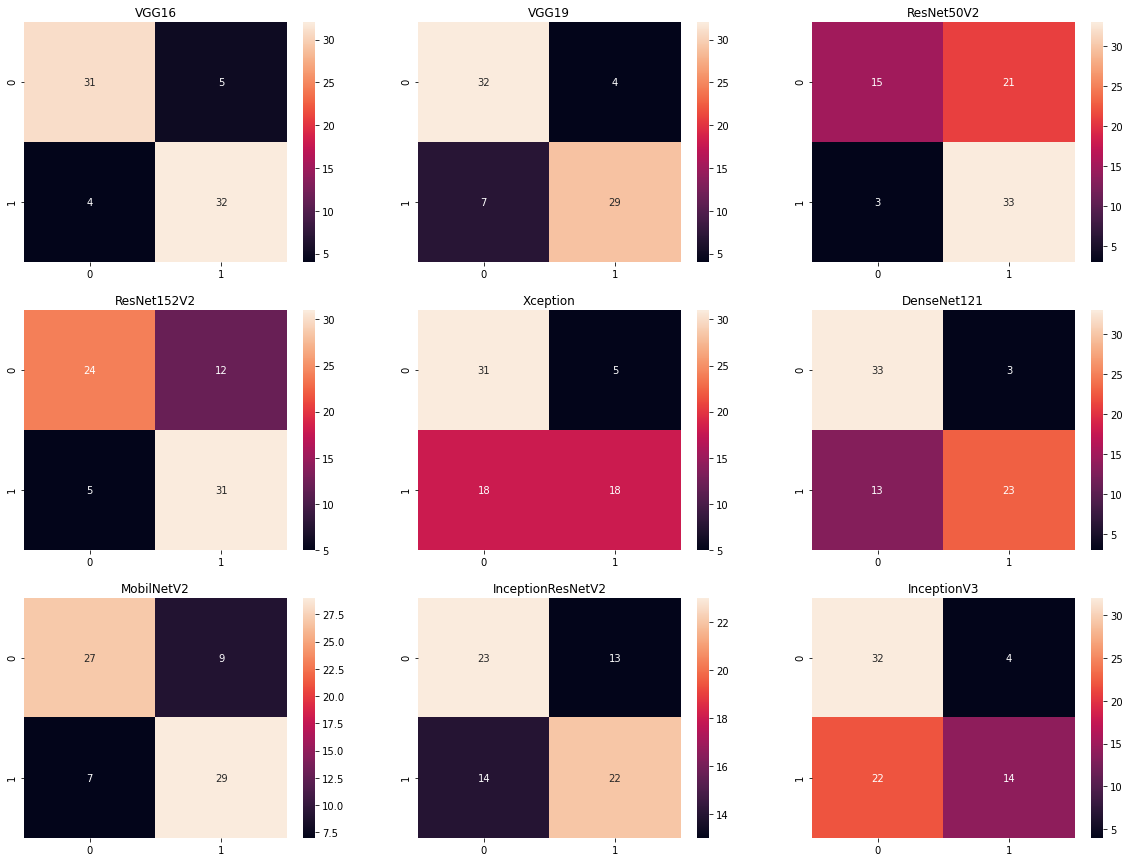

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(331)
MakeHeatmap('VGG16.h5',x_test,y_test,0.5)
plt.subplot(332)
MakeHeatmap('VGG19.h5',x_test,y_test,0.5)
plt.subplot(333)
MakeHeatmap('ResNet50V2.h5',x_test,y_test,0.5)
plt.subplot(334)
MakeHeatmap('ResNet152V2.h5',x_test,y_test,0.5)
plt.subplot(335)
MakeHeatmap('Xception.h5',x_test,y_test,0.5)
plt.subplot(336)
MakeHeatmap('DenseNet121.h5',x_test,y_test,0.5)
plt.subplot(337)
MakeHeatmap('MobilNetV2.h5',x_test,y_test,0.5)
plt.subplot(338)
MakeHeatmap('InceptionResNetV2.h5',x_test,y_test,0.5)
plt.subplot(339)
MakeHeatmap('InceptionV3.h5',x_test,y_test,0.5)
plt.show()

The best result is made by the VGG16 as we see.
Lets go further with this. Try to teach further some of the CNN layers

#Unfreeze some of the CNN weights

In [ ]:
model = TransferLearningModel('VGG16')
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
for layer in model.layers[:15]: #the layers's weight above the 10.layer are trainable now
       layer.trainable = False
for layer in model.layers[15:]:
       layer.trainable = True

In [ ]:
checkpointer=ModelCheckpoint(filepath='VGG16_unfrost.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=[checkpointer,earlystopping])

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 0.7913 - accuracy: 0.5417
Epoch 00001: val_loss improved from inf to 0.65205, saving model to VGG16_unfrost.h5
15/15 [==============================] - 3s 178ms/step - loss: 0.7913 - accuracy: 0.5417 - val_loss: 0.6521 - val_accuracy: 0.5703
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.7337 - accuracy: 0.5924
Epoch 00002: val_loss improved from 0.65205 to 0.61325, saving model to VGG16_unfrost.h5
15/15 [==============================] - 3s 171ms/step - loss: 0.7337 - accuracy: 0.5924 - val_loss: 0.6132 - val_accuracy: 0.5781
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.6008
Epoch 00003: val_loss improved from 0.61325 to 0.60764, saving model to VGG16_unfrost.h5
15/15 [==============================] - 3s 171ms/step - loss: 0.6542 - accuracy: 0.6008 - val_loss: 0.6076 - val_accuracy: 0.6328
Epoch 4/40
15/15 [==============================] - ETA: 0s - 

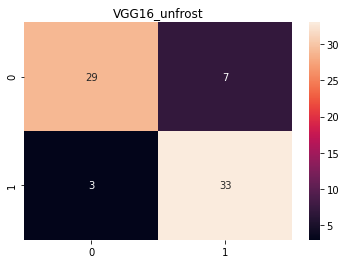

In [ ]:
MakeHeatmap('VGG16_unfrost.h5',x_test,y_test,0.5)

As we can see the result is almost the same as before, maybe a bit better.


# Load more data

We downloaded data from 3 different sources in the beginning of the code, but now we have to organize it properly to be able to use the flow_from_directory function. (We have to use DataGenerator functions, because there is not enough RAM available to store all the images.)

In [ ]:
covid_all = []
notcovid_all = []

image_path = '/content/covid-chestxray-dataset/images'
image_names=os.listdir(image_path)
with open('/content/covid-chestxray-dataset/metadata.csv') as csv_file: #load the csv from the session storage
    csv_reader = csv.reader(csv_file, delimiter=',') # ',' is the separating character
    for row in csv_reader:
        if row[23] in image_names: # check if we have the x-ray image for this diagnosis
            if row[5]=='Y': #positive covid test
                covid_all.append(os.path.join(image_path, row[23]))
            if row[5]=='': # negative covid test
                notcovid_all.append(os.path.join(image_path, row[23]))

image_path = '/content/Figure1-COVID-chestxray-dataset/images'
image_names=os.listdir(image_path)
with open('/content/Figure1-COVID-chestxray-dataset/metadata.csv', encoding='latin1') as csv_file: #load the csv from the session storage
    csv_reader = csv.reader(csv_file, delimiter=',') # ',' is the separating character
    for row in csv_reader:
        if (row[0]+'.jpg') in image_names: # check if we have the x-ray image for this diagnosis
            if row[4] == 'COVID-19': #positive covid test
                covid_all.append(os.path.join(image_path, row[0]+'.jpg'))
            else: # negative covid test
                notcovid_all.append(os.path.join(image_path, row[0]+'.jpg'))

image_path = '/content/Actualmed-COVID-chestxray-dataset/images'
image_names=os.listdir(image_path)
with open('/content/Actualmed-COVID-chestxray-dataset/metadata.csv') as csv_file: #load the csv from the session storage
    csv_reader = csv.reader(csv_file, delimiter=',') # ',' is the separating character
    for row in csv_reader:
        if row[10] in image_names: # check if we have the x-ray image for this diagnosis
            if row[4] == 'COVID-19': #positive covid test
                covid_all.append(os.path.join(image_path, row[10]))
            else: # negative covid test
                notcovid_all.append(os.path.join(image_path, row[10]))

covid_path = '/content/COVID-19 Radiography Database/COVID-19'
covid_names = os.listdir(covid_path)
for row in covid_names:
    covid_all.append(os.path.join(covid_path, row))
normal_path = '/content/COVID-19 Radiography Database/NORMAL'
normal_names = os.listdir(normal_path)
for row in normal_names:
    notcovid_all.append(os.path.join(normal_path, row))
pneumonia_path = '/content/COVID-19 Radiography Database/Viral Pneumonia'
pneumonia_names = os.listdir(pneumonia_path)
for row in pneumonia_names:
    notcovid_all.append(os.path.join(pneumonia_path, row))

In [ ]:
covid_train, covid_tmp = train_test_split(covid_all, test_size=0.3, shuffle=True)
covid_valid, covid_test = train_test_split(covid_tmp, test_size=0.33, shuffle=True)

notcovid_train, notcovid_tmp = train_test_split(notcovid_all, test_size=0.3, shuffle=True)
notcovid_valid, notcovid_test = train_test_split(notcovid_tmp, test_size=0.33, shuffle=True)

In [ ]:
train_dir = '/content/train'
valid_dir = '/content/valid'
test_dir = '/content/test'

In [ ]:
def convert_and_copy(filename, where):
    img = cv2.imread(filename, 0)
    rgb = np.stack((img,img,img), axis=2)
    im = Image.fromarray(rgb)
    im.save(os.path.join(where, filename.split('/')[-1]))

try:
  os.mkdir(train_dir)
  os.mkdir(os.path.join(train_dir, 'b_covid'))
  os.mkdir(os.path.join(train_dir, 'a_notcovid'))
except:
  print('Train folder already exists.')
for i in covid_train:
  convert_and_copy(i, os.path.join(train_dir, 'b_covid'))
for i in notcovid_train:
  convert_and_copy(i, os.path.join(train_dir, 'a_notcovid'))

try:
  os.mkdir(valid_dir)
  os.mkdir(os.path.join(valid_dir, 'b_covid'))
  os.mkdir(os.path.join(valid_dir, 'a_notcovid'))
except:
  print('Validation folder already exists.')
for i in covid_valid:
  convert_and_copy(i, os.path.join(valid_dir, 'b_covid'))
for i in notcovid_valid:
  convert_and_copy(i, os.path.join(valid_dir, 'a_notcovid'))

try:
  os.mkdir(test_dir)
  os.mkdir(os.path.join(test_dir, 'b_covid'))
  os.mkdir(os.path.join(test_dir, 'a_notcovid'))
except:
  print('Test folder already exists.')
for i in covid_test:
  convert_and_copy(i, os.path.join(test_dir, 'b_covid'))
for i in notcovid_test:
  convert_and_copy(i, os.path.join(test_dir, 'a_notcovid'))

Now, the images have been copied to our properly organized folders, so we can delete the downloaded folders to save up disk space.

In [ ]:
!rm -rf '/content/covid-chestxray-dataset'
!rm -rf '/content/Figure1-COVID-chestxray-dataset'
!rm -rf '/content/Actualmed-COVID-chestxray-dataset'
!rm -rf '/content/COVID-19 Radiography Database'

Load the previously trained model for transfer learning.

In [ ]:
model = load_model('VGG16_unfrost.h5')
for layer in model.layers[:15]: #the layers's weight above the 15.layer are trainable now
    layer.trainable = False
for layer in model.layers[15:]:
    layer.trainable = True
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=True)
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=True)

Found 2738 images belonging to 2 classes.
Found 785 images belonging to 2 classes.


In [ ]:
checkpointer = ModelCheckpoint(filepath='VGG16_bigdata.h5', save_best_only=True, verbose=1) #We save the best model with checkpointer
earlystopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
modelHistory = model.fit_generator(train_generator, steps_per_epoch=80, validation_data=valid_generator, validation_steps=10, epochs=15, callbacks=[checkpointer, earlystopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
80/80 [==============================] - ETA: 0s - loss: 0.4472 - accuracy: 0.8260
Epoch 00001: val_loss improved from inf to 0.22594, saving model to VGG16_bigdata.h5
80/80 [==============================] - 135s 2s/step - loss: 0.4472 - accuracy: 0.8260 - val_loss: 0.2259 - val_accuracy: 0.8781
Epoch 2/15
80/80 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.8614
Epoch 00002: val_loss did not improve from 0.22594
80/80 [==============================] - 120s 1s/step - loss: 0.2473 - accuracy: 0.8614 - val_loss: 0.2763 - val_accuracy: 0.9094
Epoch 3/15
80/80 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.8877
Epoch 00003: val_loss did not improve from 0.22594
80/80 [==============================] - 116s 1s/step - loss: 0.2232 - accuracy: 0.8877 - val_loss: 0.2854 - val_accuracy: 0.8906
Epoch 4/15
80/80 [==============================] - ETA: 0s - los

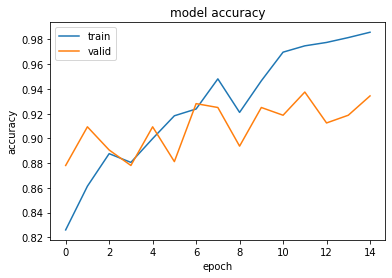

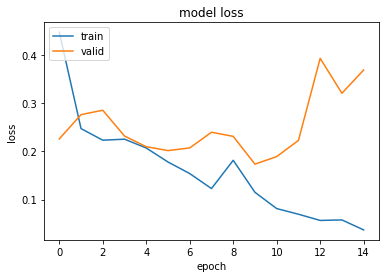

In [ ]:
# summarize history for accuracy
plt.plot(modelHistory.history['accuracy'])
plt.plot(modelHistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(modelHistory.history['loss'])
plt.plot(modelHistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
#preparing the test split
x_test_bigdata= []
y_test_bigdata= []

covid_test_path = '/content/test/b_covid'
covid_test_names = os.listdir(covid_test_path)
for i in covid_test_names:
    img = cv2.imread(os.path.join(covid_test_path, i)) # load the image
    
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA) # resize the image to 224*224
    x_test_bigdata.append(img)
    y_test_bigdata.append(True)
notcovid_test_path = '/content/test/a_notcovid'
notcovid_test_names = os.listdir(notcovid_test_path)
for i in notcovid_test_names:
    img = cv2.imread(os.path.join(notcovid_test_path, i)) # load the image
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA) # resize the image to 224*224
    x_test_bigdata.append(img)
    y_test_bigdata.append(False)

x_test_bigdata = np.asarray(x_test_bigdata)
y_test_bigdata = np.asarray(y_test_bigdata)

x_test_bigdata = x_test_bigdata.astype(float)

x_test_bigdata = x_test_bigdata/255

#Analyze

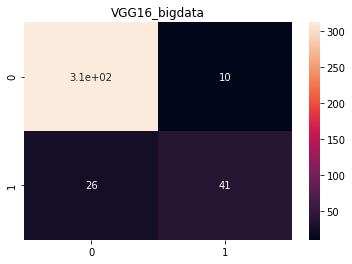

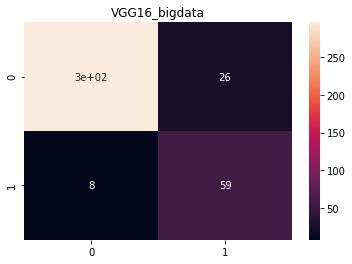

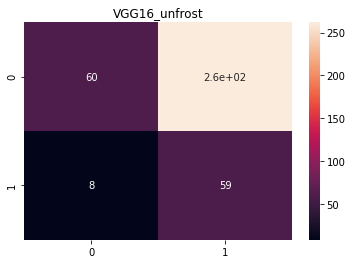

In [ ]:
MakeHeatmap('VGG16_bigdata.h5',x_test_bigdata,y_test_bigdata,0.5) #with boarder 0.5 
plt.show()
MakeHeatmap('VGG16_bigdata.h5',x_test_bigdata,y_test_bigdata,0.3) #it works very well when we separate the predicts around 0.3, it is beacause of the unbalanced inputs 
plt.show()
MakeHeatmap('VGG16_unfrost.h5',x_test_bigdata,y_test_bigdata,0.5)
plt.show()

We can see the network is doing much better after the last learning according to our new test dataset.



Lets take a closer look at the predicts

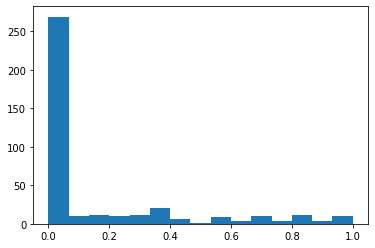

In [ ]:
model=load_model('VGG16_bigdata.h5')
predict = model.predict(x_test_bigdata)
plt.hist(predict[:,0], bins = 15)
plt.show()

We can see here the unbalanced input's effect.

In [ ]:
#lets separate the test data according the result
FN = 0
FP = 0
TN = 0
TP = 0
false_negative= []
false_positive= []
true_negative= []
true_positive= []
uncertain= [] #datas from the middle of the histogram
best0=np.zeros([1,224,224,3]) #the best predict when the result was true positive
best1=np.zeros([1,224,224,3]) #the best predict when the result was true negative
max=0;
min=1;
for i in range(len(predict)):
  if (predict[i]<0.3 and y_test_bigdata[i]): #
    false_negative.append(x_test_bigdata[i])
    FN = FN+1
  elif (predict[i]>=0.3 and y_test_bigdata[i]==0):
    false_positive.append(x_test_bigdata[i])
    FP = FP+1
  elif (predict[i]>=0.3 and y_test_bigdata[i]):
    true_positive.append(x_test_bigdata[i])
    TP = TP+1
    if (predict[i]>max):
      best1[0,:,:,:]=x_test_bigdata[i]
      max=predict[i]
  elif (predict[i]<0.3 and y_test_bigdata[i]==0):
    true_negative.append(x_test_bigdata[i])
    TN = TN+1
    if (predict[i]<min):
      best0[0,:,:,:]=x_test_bigdata[i]
      min=predict[i]
  if predict[i]<0.4 and predict[i]>0.2:
    uncertain.append(x_test_bigdata[i])


f_n = np.asarray(false_negative)
f_p = np.asarray(false_positive)
t_n = np.asarray(true_negative)
t_p = np.asarray(true_positive)
uc=np.asarray(uncertain)

print('false negatives: ', FN)
print('false positives: ', FP)
print('true negatives: ', TN)
print('true positives: ', TP)

false negatives:  8
false positives:  26
true negatives:  296
true positives:  59


In [ ]:
accuracy = (TP+TN)/(TP+FN+FP+TN)
recall = TP/(TP+FN)
specificity = TN/(TN+FP)
precision = TP/(TP+FP)

print('accuracy:', accuracy)
print('recall:', recall)
print('specificity:', specificity)
print('precision:', precision)

accuracy: 0.9125964010282777
recall: 0.8805970149253731
specificity: 0.9192546583850931
precision: 0.6941176470588235


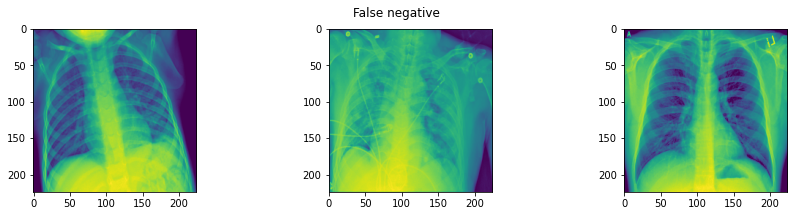

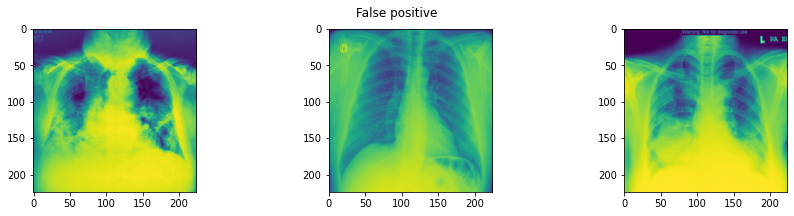

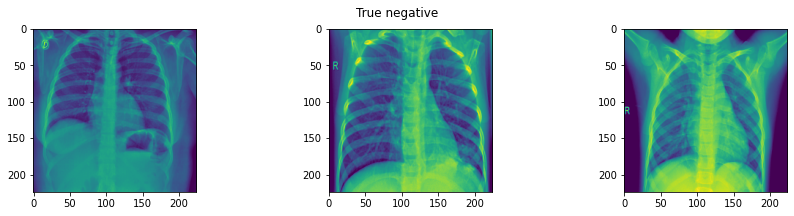

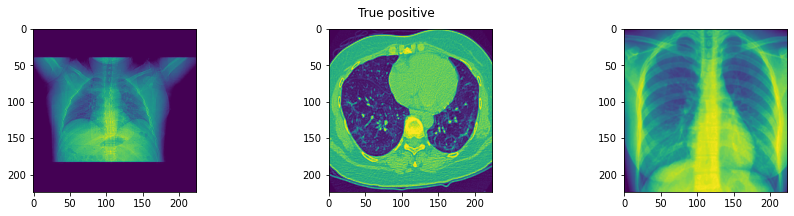

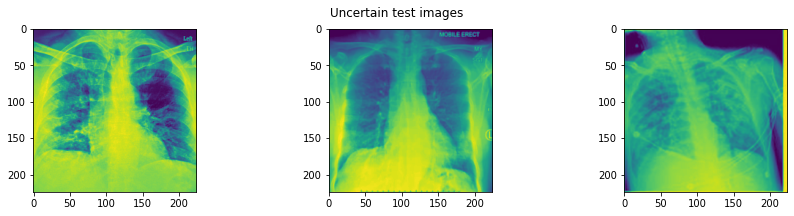

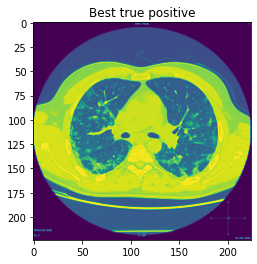

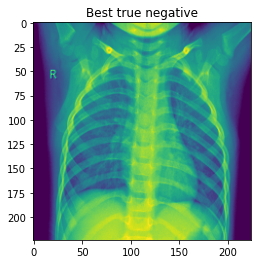

In [ ]:
def plot_3_pic(title,array):
  plt.figure(figsize=(15, 3))
  plt.subplot(131)
  plt.imshow(array[0,:,:,0])
  plt.subplot(132)
  plt.imshow(array[1,:,:,0])
  plt.subplot(133)
  plt.imshow(array[2,:,:,0])
  plt.suptitle(title)
  plt.show()

plot_3_pic('False negative',f_n)
plot_3_pic('False positive',f_p)
plot_3_pic('True negative',t_n)
plot_3_pic('True positive',t_p)
plot_3_pic('Uncertain test images',uc)

plt.imshow(best1[0,:,:,0])
plt.title('Best true positive')
plt.show()
plt.imshow(best0[0,:,:,0])
plt.title('Best true negative')
plt.show()

Interesting that we can barely see any categorical difference between the groups, but our network can separate them "pretty" well.

Lets plot some feature map maybe we can notice which features makes the diference in the prediction.

In [ ]:
from tensorflow.keras.models import Model

def check_feature_maps(x):
  successive_outputs = [model.layers[2].output,model.layers[10].output, model.layers[16].output] #Check the results in the 2nd, 10th and 18th layers
  visualization_model = Model(model.input, successive_outputs) #we create a new model where we only care about the inside CNN layers we are curious for 
  successive_feature_maps = visualization_model.predict(x)
  for feature_map in successive_feature_maps:
      n_features =25 #feature_map.shape[-1]  #we could plot all depth, but there is 64 already in the 1st CNN layer, we cant handle that much -> plot only 10 from each
      size = feature_map.shape[1]
      display_grid = np.zeros((size, size * n_features))
      for i in range(n_features):
        x = feature_map[0, :, :, i]
        # lets convert the images to make them spectacular
        x -= x.mean()
        x /= x.std()
        x *= 64
        x += 128        
        x = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x
      # Display the grid
      scale = 20. / n_features
      plt.figure(figsize=(scale * n_features, scale))
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


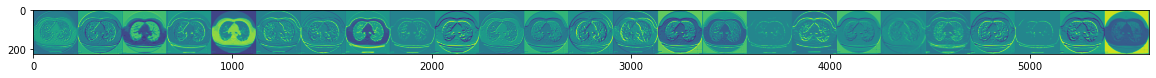

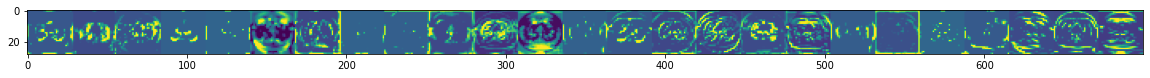

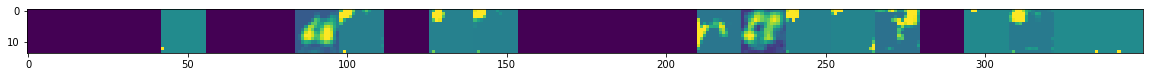

In [ ]:
check_feature_maps(best1) #the best true positive predict from the test dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


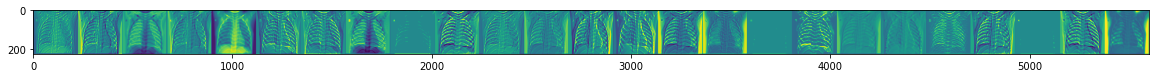

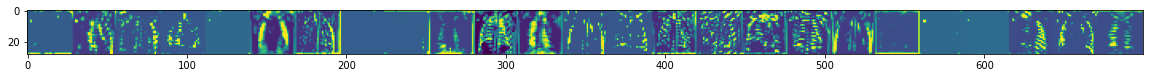

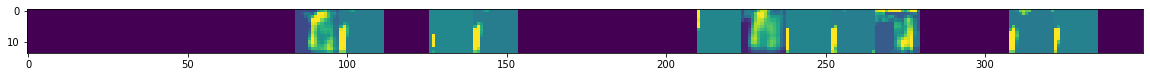

In [ ]:
check_feature_maps(best0) #the best true negative predict from the test dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


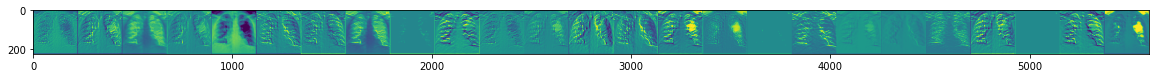

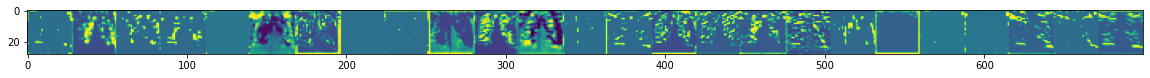

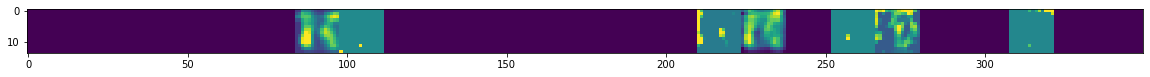

In [ ]:
x=np.zeros([1,224,224,3])
x[0,:,:,:]=uc[0] # one of the uncertain predictions recommended to watch the last ploted feature map
check_feature_maps(x)

The influencing feature maps are where are lot of light pixels -> those kernels are the most important. We can see in the last plot, the same depths are active, those are the determinating features.